In [1]:
#Project 1: numdiff

#importing libraries
%matplotlib inline 
import numpy as np
import time
import seaborn as sns
import matplotlib.pyplot as plt
newparams = {'figure.figsize': (8.0, 4.0), 'axes.grid': True,
             'lines.markersize': 8, 'lines.linewidth': 2,
             'font.size': 14}
from matplotlib import cm
from scipy.sparse import diags
from scipy.sparse import coo_matrix, bmat
plt.rcParams.update(newparams)

In [2]:
from sympy.solvers import solveset, S
from sympy import Symbol

# Project 1, task 1

In [3]:
def plot_solution(x, y, U, txt='Solution'):
    #Plot the solution of the equation
    
    fig, ax = plt.subplots(subplot_kw={"projection": "3d"}, figsize=(10,8))
    X, Y = np.meshgrid(x,y)
    # ax.plot_wireframe(T, X, U)
    ax.plot_surface(X, Y, U, cmap=cm.coolwarm)
    ax.view_init(azim=30)              # Rotate the figure
    plt.xlabel('x')
    plt.ylabel('y')
    plt.title(txt);
    
def SWPEN(h, a):
    #Coefficients
    S = -1
    W = -a
    P = 2*(a +1)
    E = -a
    N = -1
    return S, W, P, E, N

#boundary values
def G(x, y):
    return x**2*y**2 

#Function we solve
def F(x, y, r, a): 
    return -2*(a+1)*y**2 -8*r*x*y -2*r**2*x**2

def G2(x, y):
    return y*np.exp(x)

def F2(x, y, r, a):
    return -((1+a)*(y*np.exp(x))+2*r*np.exp(x))

def G3(x, y):
    return np.exp(x**2)

def F3(x, y, r, a):
    return -((a+1)*(4*np.exp(x**2)*x**2+2*np.exp(x**2)))

In [4]:
def create_ab(M, h, k, a, innerx, innery, G_func = G):
    '''
    M: resolution
    h: step length in x-direction
    k: step length in y-direction
    innerx, innery: inner x and y coordinates
    returns A matrix and b vector
    '''
    S, W, P, E, N = SWPEN(h, a)
    A = diags([S, W, P, E, N], [-M, -1, 0, 1, M], shape = ((M-1)**2, (M-1)**2)).toarray()   #creating matrix A, with boundaries

    b = np.zeros((M-1)**2)    #boundary conditions AU = b
    
    corner_points = np.array([(0), (M-2), ((M-1)**2 -(M-1)), ((M-1)**2-1)])
    
    for i in range(len(innerx)):    #inner x should be (M-1)**2 long
        x = innerx[i]
        y = innery[i]
        
        #Bottom Left:
        if i == corner_points[0]:
            b[i] -= S * G_func(0, 0)  #Adding South
            b[i] -= W * G_func(0, k)    #Adding West"""
            
        #Bottom right:
        if i == corner_points[1]:
            b[i] -= S* G_func(x-h, 0)  #Adding South
            b[i] -= E* G_func(x+h, y)    #Adding East
            b[i] -= N* G_func(x+h, y+k)  #Adding North
            A[i][i+1] = 0           #Putting East point to zero
            A[i][i+M] = 0           #Putting North point to zero
    
        #Top left:
        if i == corner_points[2]:
            b[i] -= N*G_func(x+h, y+k)         #Adding North
            b[i] -= W*G_func(x-h, y)           #Adding West
            b[i] -= S*G_func(x-h, y-k)         #Adding South
            A[i][i-1] = 0               #removing West
            A[i][i-M] = 0               #removing South
           
        
        #Top right:
        if i == corner_points[3]:
            b[i] -= N * G_func(x+h, y+k)       #Adding North
            b[i] -= E * G_func(x+h, y)         #Adding East
        
        #Left:
        if i % (M-1) == 0 and (i not in corner_points):
            b[i] -= S * G_func(0, y-k)     #Adding South
            b[i] -= W * G_func(0, y)       #Adding West
            A[i][i-1] = 0               #Removing West
            if (i-M) > 0:
                A[i][i-M] = 0               #Removing South 
                
            
        #Right:
        if (i % (M-1) == (M-2)) and (i not in corner_points):
            b[i] -= E* G_func(x+h, y)        #Adding East
            b[i] -= N* G_func(x+h, y+k)      #Adding North
            A[i][i+1] = 0               #Removing East
            if i+M < (M-1)**2:
                A[i][i+M] = 0           #Removing North
        
        #Top:
        if (i >= (M-1)**2 -(M-1)) and (i not in corner_points):
            b[i] -= N*G_func(x+h, y+k)
        
        #Bottom:
        if i < (M-1) and (i not in corner_points):
            b[i] -= S*G_func(x-h, y-k)
    return A, b

In [5]:
def solver1a(M, r, a, G_func = G, F_func = F):
    '''M: Number of steps
    r: length of d2
    '''
    # Set the stepsizes
    h = 1/M     # Stepsize in x
    k = 2*h     # Stepsize in y
    
    x = np.linspace(0, 1, M+1)
    y = np.linspace(0, 2, M+1)
    xv, yv = np.meshgrid(x, y)
    
    #Inserting boundary values
    U = G_func(xv, yv)
    U[1:-1, 1:-1] = 0  
    
    #creating matrix A and boundary value vector b
    innerx_coord, innery_coord = xv[1:-1,1:-1].flatten(), yv[1:-1, 1:-1].flatten()
    A, b = create_ab(M, h, k, a, innerx_coord, innery_coord, G_func)
    
    f = F_func(xv, yv, 2, a)
    f_ny = f[1:-1, 1:-1].flatten()
    
    #solving AU = f+b
    sol = np.linalg.solve(A, (h**2*f_ny) + b) 
    sol = sol.reshape((M-1, M-1))
    
    #inserting solution
    U[1:-1, 1:-1] = sol
    
    
    return x, y, U


In [10]:
def convergence(exact_func, M, solver=solver1a): 
    P = 6
    Hconv = np.zeros(P)
    Econv = np.zeros(P)
    M = 4             
    for p in range(P):
        x, y, U = solver(M, r = 2, a = 1)
        X, Y = np.meshgrid(x, y)
        #print('e:', exact_func(X, Y))
        Eh = exact_func(X, Y)-U
        #print(np.max(np.abs(Eh)))
        Hconv[p] = (x[1]-x[0])
        Econv[p] = np.max(np.abs(Eh))
        M = 2*M
    print(Econv)
    print(Hconv)
    order = np.polyfit(np.log(Hconv),np.log(Econv),1)[0]
    return Hconv, Econv, order  

In [11]:
def test_and_plot(solver, M, r, a, G_func = G, F_func = F, title = 'title'):
    x, y, U = solver(M, r, a, G_func, F_func)
    
    X, Y = np.meshgrid(x, y)
    plot_solution(x, y, U, txt = title) 
    plot_solution(x, y, G_func(X, Y), txt = 'Exact solution')
    plot_solution(x, y, G_func(X, Y)-U, txt = 'Error')
    
    H, E, p = convergence(G, 4, solver1a)
    #print(H,E)
    plt.figure(9)
    plt.loglog(H,E,'o-', label='p={:.2f}'.format(p))
    plt.title(f'Degree of convergence for {title}')
    plt.grid('on')
    plt.xlabel('h')
    plt.ylabel('error')
    plt.legend()

[2.78716216e-02 6.77254747e-03 1.68426863e-03 4.20613438e-04
 1.05128090e-04 2.62805559e-05]
[0.25      0.125     0.0625    0.03125   0.015625  0.0078125]


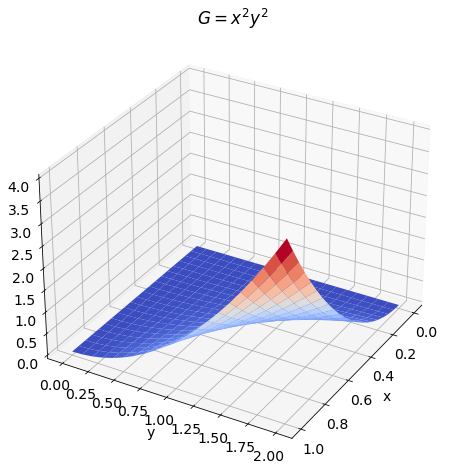

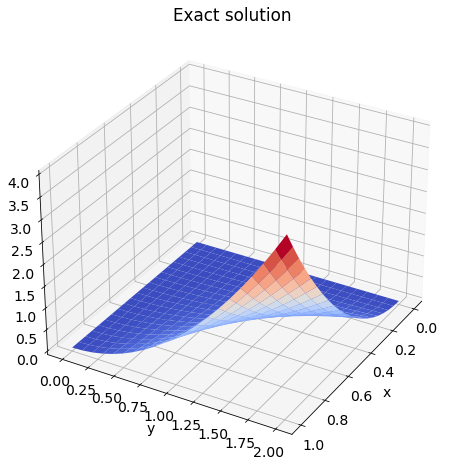

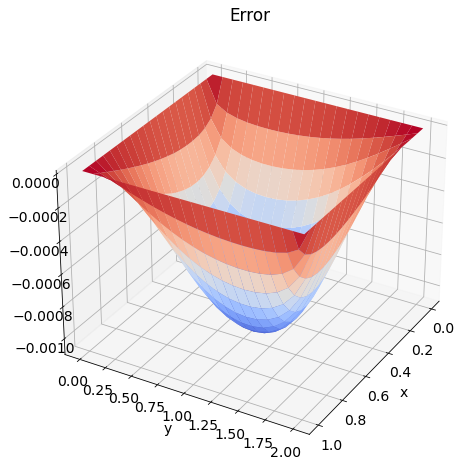

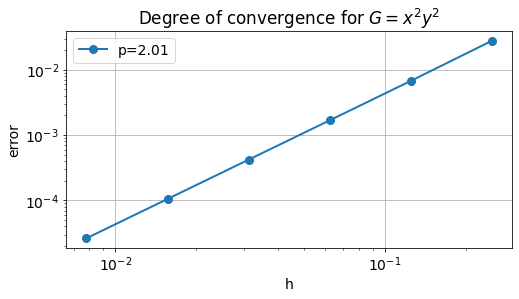

In [12]:
test_and_plot(solver1a, 20, 2, 1, G, F, title = '$G = x^2y^2$')

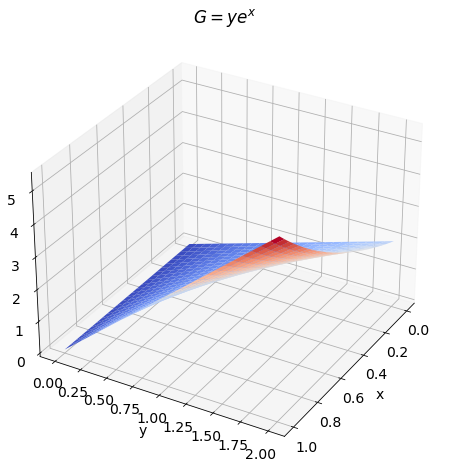

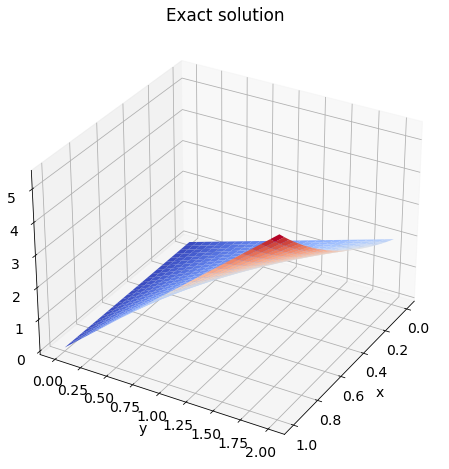

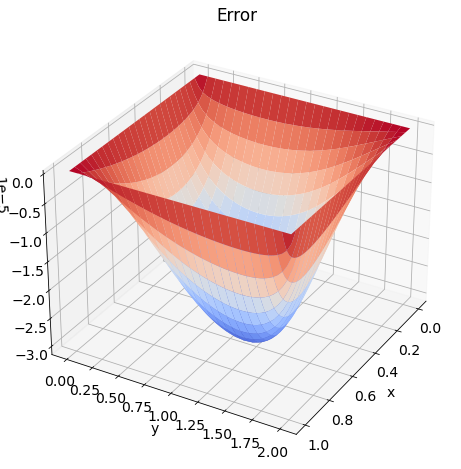

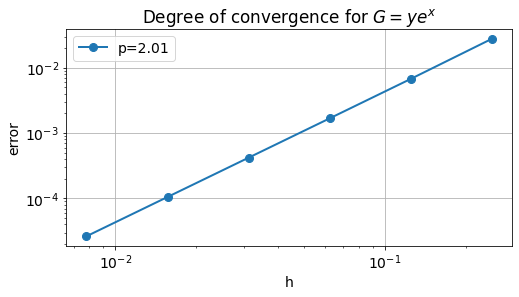

In [ ]:
test_and_plot(solver1a, 20, 2, 1, G2, F2, title = '$G = y e^x$')

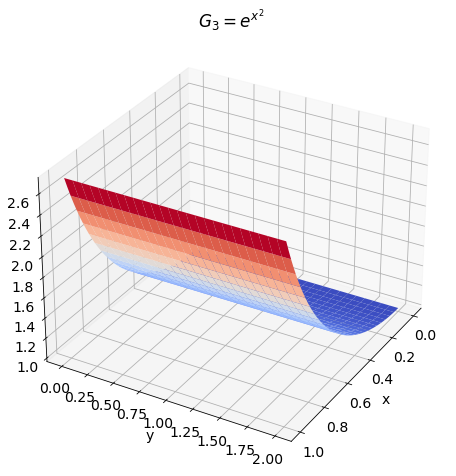

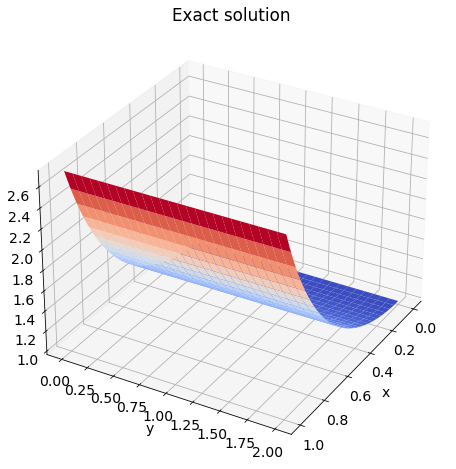

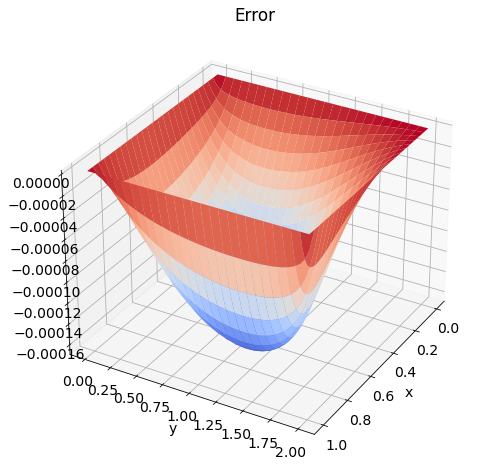

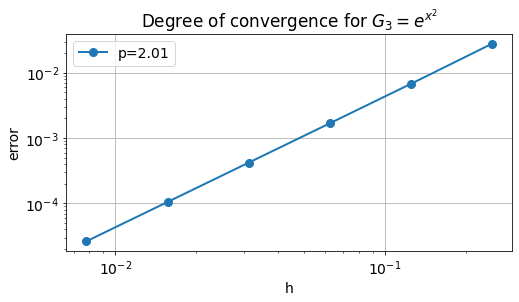

In [ ]:
test_and_plot(solver1a, 50, 2, 1, G3, F3, title = '$G_3 = e^{x^2}$')

## 1d)

In [ ]:
def create_ab__(N, M, h, k, a, innerx, innery, G_func = G):
    '''
    N: # steps in y-direction
    M: # steps in x-direction
    h: step length in x-direction
    k: step length in y-direction
    innerx, innery: inner x and y coordinates
    returns A matrix and b vector
    '''

    S, W, P, E, North = SWPEN(h, a)
    A = diags([S, W, P, E, North], [-M, -1, 0, 1, M], shape = ((M-1)*(N-1), (M-1)*(N-1))).toarray()   #creating matrix A, with boundaries

    b = np.zeros((M-1)*(N-1))    #boundary conditions AU = b
    corner_points = np.array([(0), (M-2), (N-1)*(M-1) -(M-1), (N-1)*(M-1)-1])    #sjekket
    
    for i in range(len(innerx)):    #inner x should be (M-1)**2 long
        x = innerx[i]
        y = innery[i]
        
        
        #Bottom Left:
        if i == corner_points[0]:
            b[i] -= S* G_func(0, 0)  #Adding South
            b[i] -= W* G_func(0, y)    #Adding West"""
        
        
        #Bottom right:
        if i == corner_points[1]:
            b[i] -= S * G_func(x-h, 0)  #Adding South
            b[i] -= E * G_func(1, y)    #Adding East
            b[i] -= North * G_func(1, y+k)  #Adding North
            A[i][i+1] = 0           #Putting East point to zero
            A[i][i+M] = 0           #Putting North point to zero
    
        #Top left:
        if i == corner_points[2]:
            b[i] -= North * G_func(x+h, 2)         #Adding North
            b[i] -= W * G_func(0, y)           #Adding West
            b[i] -= S * G_func(0, y-k)         #Adding South
            A[i][i-1] = 0               #removing West
            A[i][i-M] = 0               #removing South
           
        
        #Top right:
        if i == corner_points[3]:
            b[i] -= North * G_func(1, 2)       #Adding North
            b[i] -= E * G_func(1, y)         #Adding East
        
        
        #Left:
        if i % (M-1) == 0 and (i not in corner_points):
            b[i] -= S * G_func(0, y-k)       #Adding South
            b[i] -= W * G_func(0, y)         #Adding West
            A[i][i-1] = 0               #Removing West
            if (i-M) > 0:
                A[i][i-M] = 0           #Removing South 
                
        
        #Right:
        if (i % (M-1) == (M-2)) and (i not in corner_points):
            b[i] -= E * G_func(1, y)        #Adding East
            b[i] -= North * G_func(1, y+k)  #Adding North
            A[i][i+1] = 0              #Removing East
            if i+M < (M-1)*(N-1):
                A[i][i+M] = 0            #Removing North
        
        #Top:
        if (i >= (M-1)*(N-1) -(M-1)) and (i not in corner_points):
            b[i] -= North * G_func(x+h, 2)
        
        #Bottom:
        if i < (M-1) and (i not in corner_points):
            b[i] -= S * G_func(x-h, 0)
            
    return A, b

In [ ]:
def solver1dr(M, r= np.sqrt(2), a = 3, G_func = G, F_func = F):
    '''M: Number of steps
    r: length of d2
    '''
    # Set the stepsizes
    h = 1/M         # Stepsize in x
    k = abs(r)*h    # Stepsize in y
    
    y = np.arange(0,2+k,k)        #Gridpoints on the y-axis
    N = len(y)-1
    x = np.linspace(0,1,M+1)    # Gridpoints on the x-axis    Nå blir x og y av ulik lengde.
    
    xv, yv = np.meshgrid(x, y)
    
    U = G_func(xv, yv)
    
    U[1:-1, 1:-1] = 0
    
    innerx_coord, innery_coord = xv[1:-1,1:-1].flatten(), yv[1:-1, 1:-1].flatten()  #Hver koordinat i a og b angir ett punkt
    
    A, b = create_ab__(N, M, h, k, a, innerx_coord, innery_coord, G_func)
    np.savetxt('matrixdebug.txt', A, fmt='%3.1d')
    
    
    f = F_func(xv, yv, r, a)
    f_ny = f[1:-1, 1:-1].flatten()
    
    sol = np.linalg.solve(A, (h**2*f_ny) + b) 
    sol = sol.reshape((N-1, M-1))
    
    U[1:-1, 1:-1] = sol
    
    return x, y, U


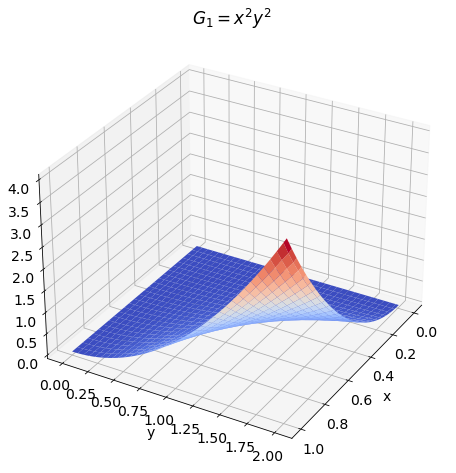

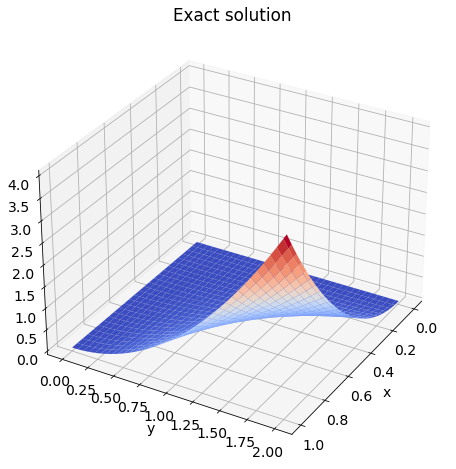

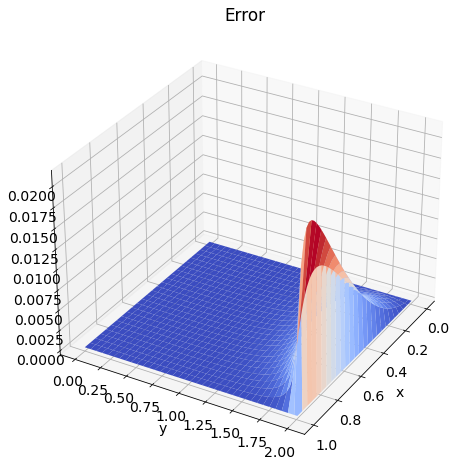

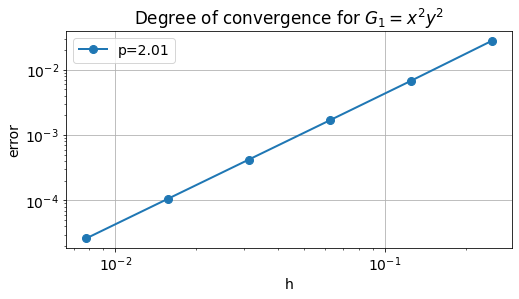

In [ ]:
test_and_plot(solver1dr, 50, np.sqrt(2), 3, G, F, title = '$G_1 = x^2y^2$')

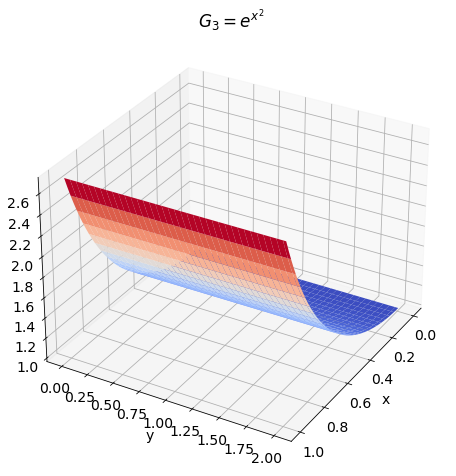

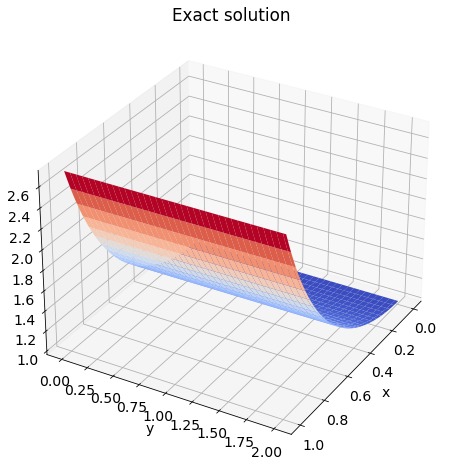

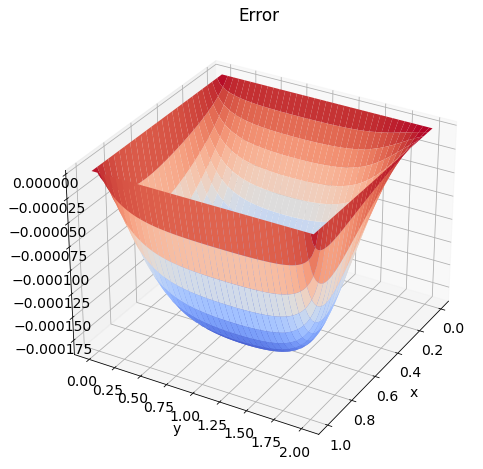

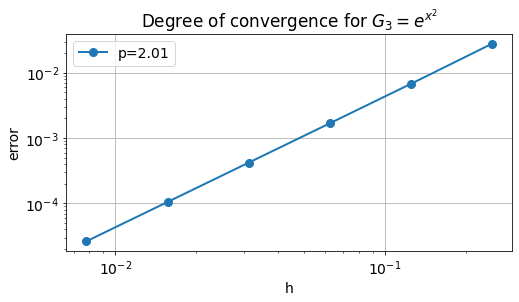

In [ ]:
test_and_plot(solver1dr, 50, np.sqrt(2), 3, G3, F3, title = '$G_3 = e^{x^2}$')

# Project 1, task 2


In [ ]:
def grid(M):
    x = np.linspace(0,1,M+1)
    y = np.linspace(0,1,M+1)

    xx, yy = np.meshgrid(x,y)
    G = 1-xx**2 > yy

    v = np.where(G[1:-1, 1:-1] == True) #v[y][x]

    U_grid = np.zeros((G.shape[0],G.shape[1]))
    boundary_indicies = np.zeros(G.shape[0])    
    
    for i in range(G.shape[0]):
        for j in range(G.shape[1]):
            if G[i][j] == True:
                U_grid[i][j] = 1
            else:
                boundary_indicies[i] = j
                break
    
    return x, y, xx, yy, U_grid, G, v

In [ ]:
#defining matrix A
def A_fat(M, S, W, P, E, N, Omega):
    A = diags([S, W, P, E, N], [-(M-1), -1, 0, 1, (M-1)], shape = ((M-1)**2, (M-1)**2)).toarray()  #M-1 
    for i in range(M-2):
        k = (M-1)*(i+1)
        A[k-1, k]= 0
        A[k, k-1]= 0
    
    #print(Omega)
    #bretter ut omega
    Omega = Omega[1:-1, 1:-1].flatten()     #Omega contains True if element inside area, False if outside
    #print(Omega)
    count = np.count_nonzero(Omega == True)
    i = 0
    
    #Fjerner rader og kolonner som er utenfor omega
    while len(Omega)> count:
        if not Omega[i]:
            A = np.delete(A, i, 0)  #This deletes row i
            A = np.delete(A, i, 1)  #This deletes column i
            Omega = np.delete(Omega, i)
            i -=1
        i +=1
    return A

In [ ]:
def bc_funk(x,y): #boundary cond-function
    return np.cos(x)*np.sin(y) #-1/(2*np.pi**2)*np.cos(np.pi*x)*np.cos(np.pi*y) 

def f(x,y,inner_points): #source, N = number of inner_points
    f_vector = np.zeros(len(inner_points[0]))
    for i in range(len(inner_points[0])):
        x_p = x[0][inner_points[1][i]]
        y_p = y[inner_points[0][i]][0]
        f_vector[i]=  -2*np.sin(y_p)*np.cos(x_p) #np.cos(np.pi*y_p)*np.cos(np.pi*x_p)
    return f_vector

def projection(x, y):    #projeksjon får problem med compleks verdier
    '''r = Symbol('r', real = True)
    projection_function = x+r*(1-2*y)-2*r**3
    r_sol = np.array(solve(projection_function, r))
    #print(r_sol.real)
    r_val = max(r_sol)
    print(r_val)
    projection =  np.array([(r_val), float(1-r_val**2)])'''
    
    r = Symbol('r')
    projection_function = x+r*(1-2*y)-2*r**3
    sols = solveset(projection_function, r, domain=S.Reals)
    sol = None
    for s in sols:
        if s >= 0:
            sol = s
    if sol is None:
        raise Exception('Could not solve')
    return float(sol)

def g_fattening(xx, yy, bc_funk, inner_points, U_grid, h): #g-vector for boundary 
    #bc: bndry cond 
    #inner_points: vector with indicies omega
    #U_grid: full grid (1s and 0s)

    g = np.zeros(len(inner_points[0]))
    
    for i in range(len(g)):
        if inner_points[0][i] == 0: #nedre BC
            y_s= yy[inner_points[0][i]][0]
            x = xx[0][inner_points[1][i]+1]
            g[i] += bc_funk(x, y_s)


            
        if inner_points[1][i] == 0: #venstre BC
            x_e = xx[0][inner_points[1][i]]
            y = yy[inner_points[0][i]+1][0]
            g[i] += bc_funk(x_e, y)

    
           
        if U_grid[inner_points[0][i]+2][inner_points[1][i]+1] == 0: #øvre BC
            x_val = xx[0][inner_points[1][i]+1]
            y_val = yy[inner_points[0][i]+2][0]
            r = projection(x_val, y_val)
            xy_projection = [r, 1-r**2]
            g[i] += bc_funk(xy_projection[0], xy_projection[1])

          
    
        if U_grid[inner_points[0][i]+1][inner_points[1][i]+2] == 0: #høyre BC
            x_val = xx[0][inner_points[1][i]+2]
            y_val =yy[inner_points[0][i]+1][0]
            r = projection(x_val, y_val)
            xy_projection = [r, 1-r**2]
            g[i] += bc_funk(xy_projection[0], xy_projection[1])

            
    return g

In [ ]:
def B_north_irregular(xx, yy, inner_points, U_grid, h): #irregular grid
   
    B_north = np.zeros((len(inner_points[0]),len(inner_points[0])))
   # print(inner_points[0])
    #print(np.shape(U_grid))
        
    for i in range(len(inner_points[0])):
    
        if U_grid[inner_points[0][i]+2][inner_points[1][i]+1] == 0: #øvre BC
    
            y_p= yy[inner_points[0][i]+1][0]
            x_p = xx[0][inner_points[1][i]+1]
            y_boundary = 1-x_p**2
            #y_s = yy[inner_points[0][i]][0]
            h_b = y_boundary- y_p
            eta = h_b/h
            
            
            
            indeks_s = 0
            for j in range(len(inner_points[0])):
                if inner_points[0][i]-1 == inner_points[0][j] and inner_points[1][i]== inner_points[1][j] :
                    indeks_s = j
            
            B_north[i][i] = (2-2/eta)
            B_north[i][indeks_s]  = -(1-2/(1+eta))
            
           # print(eta, i)

    return B_north

In [ ]:
def B_east_irregular(xx, yy, inner_points, U_grid, h): #irregular grid
    #bc: bndry cond 
    #inner_points: vector with indicies omega
    #U_grid: full grid (1s and 0s)

            
    B_east = np.zeros((len(inner_points[0]),len(inner_points[0])))
        
    for i in range(len(inner_points[0])):

        if U_grid[inner_points[0][i]+1][inner_points[1][i]+2] == 0: #høyre BC
            
            x_p= xx[0][inner_points[1][i]+1]
            y_p =yy[inner_points[0][i]+1][0]
            x_boundary = np.sqrt(1-y_p)
            h_b= x_boundary-x_p
            eta = h_b/h
            #x_e = xx[0][inner_points[1][i]]
            
            B_east[i][i] = (2-2/eta)
            B_east[i][i-1] = -(1-2/(1+eta))

           
            
    return B_east

In [ ]:
def g_irregular(xx, yy, bc_funk, inner_points, U_grid, h): #irregular grid
    #bc: bndry cond 
    #inner_points: vector with indicies omega
    #U_grid: full grid (1s and 0s)

    g = np.zeros(len(inner_points[0]))
    
    for i in range(len(g)):
        if inner_points[0][i] == 0: #nedre BC
            y_s= yy[inner_points[0][i]][0]
            x = xx[0][inner_points[1][i]+1]
            g[i] += bc_funk(x, y_s)
    
        if inner_points[1][i] == 0: #venstre BC
            x_e = xx[0][inner_points[1][i]]
            y = yy[inner_points[0][i]+1][0]
            g[i] += bc_funk(x_e, y)
            
    
        if U_grid[inner_points[0][i]+2][inner_points[1][i]+1] == 0: #øvre BC
            y_p= yy[inner_points[0][i]+1][0]
            x_p = xx[0][inner_points[1][i]+1]
            y_boundary = 1-x_p**2
            y_s = yy[inner_points[0][i]][0]
            h_b = y_boundary- y_p
            eta = h_b/h
            
            g[i] += (2/(eta*(eta+1)))*bc_funk(x_p, y_boundary)

        if U_grid[inner_points[0][i]+1][inner_points[1][i]+2] == 0: #høyre BC
            
            x_p= xx[0][inner_points[1][i]+1]
            y_p =yy[inner_points[0][i]+1][0]
            x_boundary = np.sqrt(1-y_p)
            h_b= x_boundary-x_p
            eta = h_b/h
            x_e = xx[0][inner_points[1][i]]

            g[i] += 2/(eta*(eta+1))*bc_funk(x_boundary, y_p)
            
            
    return g

In [ ]:
def solver_task2(A, f_funk, bc_funk, M, grid, g_bndry, B_east_irregular, B_north_irregular, a = 1, irregular = False):  

    h = 1/M
    k = h 

    S = -1
    W = -a
    P = 1 *(2*a +2)
    E = -a
    N = -1
    
    x, y, xx, yy, U, Omega, inner_points = grid(M) #inner_points: tuple with the inner points 

    bc = np.zeros((M+1, M+1))
    bc[:,:] = bc_funk(x,y)

    g = g_bndry(xx, yy, bc_funk, inner_points, U, h)

    f = f_funk(xx, yy, inner_points)
    Ah = A(M, S, W, P, E, N, Omega)
    #print(Ah)

    #U_inner = np.zeros(len(inner_points[0]))
    if not irregular:
        U_inner = np.linalg.solve(Ah, -f*h**2 + g) #values of inner points
    #print(Ah)
    if irregular: 
        B_north_matrix = B_north_irregular(xx, yy, inner_points, U, h)
        B_east_matrix = B_east_irregular(xx, yy, inner_points, U, h)
        U_inner = np.linalg.solve(Ah-B_north_matrix-B_east_matrix, -f*h**2 + g)
        
        #print(Ah-B_north_matrix-B_east_matrix)
        
        
    U_new = U*0
    #print(U_inner)

    for i in range(len(U_inner)):
        U_new[inner_points[0][i]+1][inner_points[1][i]+1]= U_inner[i] 

    U_new[0,:] = bc_funk(xx[0,:], 0)

    U_new[:,0] = bc_funk(0, yy[:,0])
    
    U_new[0,0] = bc_funk(0, 0)

    #print(U_new)
    
    return U_new, x, y

In [ ]:
M = 60
start_time = time.time()
U_fat , x, y = solver_task2(A_fat, f, bc_funk, M, grid, g_fattening, B_east_irregular, B_north_irregular)
end_time = time.time()
print(f"Time (fattening with M = {M}): ", end_time-start_time)


Time (fattening with M = 60):  51.27902674674988


In [ ]:
def plot_solution(x, y, U, txt='Solution'):
    # Plot the solution of the heat equation
    
    fig, ax = plt.subplots(subplot_kw={"projection": "3d"}, figsize=(15,10))
    X, Y = np.meshgrid(x,y)
    #ax.plot_wireframe(X, Y, U)
    ax.plot_surface(X, Y, U, cmap=cm.coolwarm)
    ax.view_init(azim=10)              #Rotate the figure
    plt.xlabel('x')
    
    plt.ylabel('y')
    plt.title(txt)

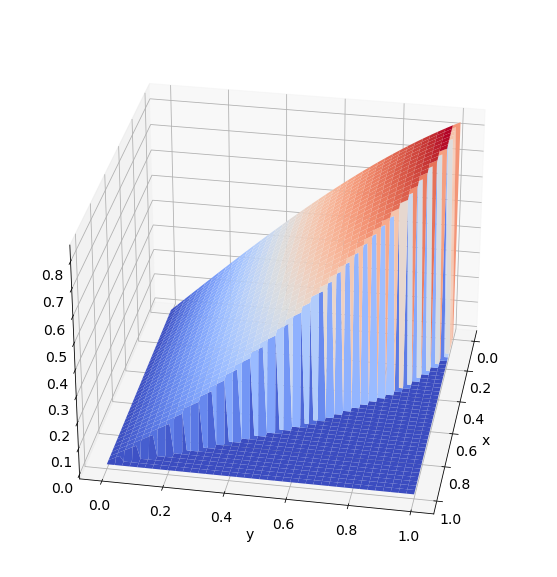

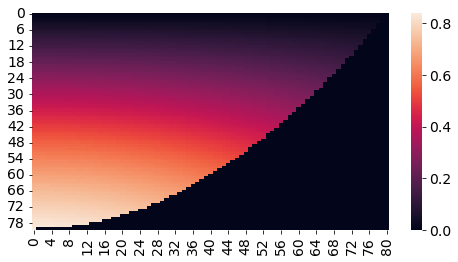

In [ ]:
# Make a 3-d plot
plot_solution(x, y, U_fat, txt=' ')
plt.show()

sns.heatmap(U_fat)
plt.show()

In [ ]:
M = 60
start_time_irr = time.time()
U_nf , x_nf, y_nf = solver_task2(A_fat, f, bc_funk, M, grid, g_irregular, B_east_irregular, B_north_irregular, irregular = True)
end_time_irr = time.time()
print(f"Time (irregular grid with M = {M}): ", end_time_irr-start_time_irr) 

Time (irregular grid with M = 60):  45.28588390350342


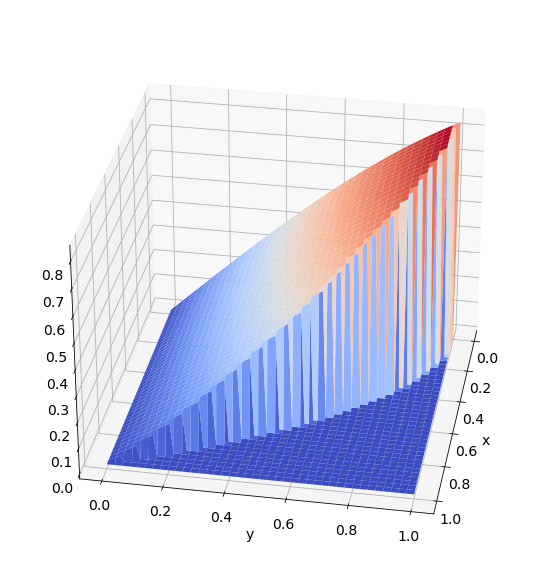

In [ ]:
plot_solution(x_nf, y_nf, U_nf, txt=' ')
plt.show()

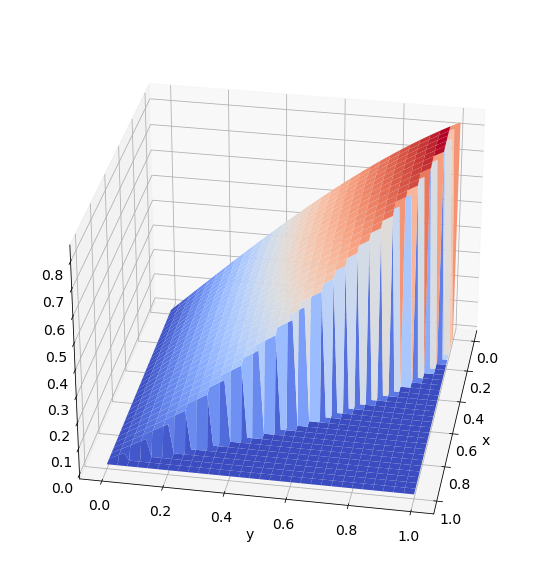

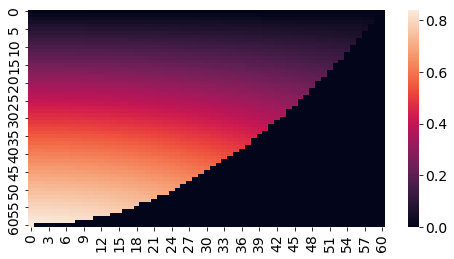

In [ ]:
def F(x,y): #exact solution 
    return  np.cos(x)*np.sin(y) #-1/(2*np.pi**2)*np.cos(np.pi*x)*np.cos(np.pi*y)

'''
def exact_solution(M, grid, a=1):
    x, y, xx, yy, U_grid, G, inner_points = grid(M)
    U_real = F(xx,yy)
    U_exact= U_real*0
    for i in range(len(inner_points[0])):
        U_exact[inner_points[1][i]+1][inner_points[0][i]+1]= U_real[inner_points[1][i]+1][inner_points[0][i]+1]
    U_exact[:,0]= U_real[:,0]
    U_exact[0,:]= U_real[0,:]
    
    return U_exact, x, y
''' #skrive på nytt

def exact_sol(M):
    x, y, X, Y, U_grid, G, inner_points = grid(M)
    # Define the mask
    U_exact = F(X,Y)
    U_exact = np.where(Y < 1 - X**2, U_exact, 0)
    return U_exact, x, y

U_exact, x_exact, y_exact = exact_sol(M)
U_exact[M, 0] = F(0,1)
plot_solution(x_exact, y_exact, U_exact, txt= ' ')
plt.show() 

sns.heatmap(U_exact)
plt.show()

In [ ]:
"""error_fattening =  U_fat - U_exact
print("Inf-norm for error, fattening: ", np.linalg.norm(error_fattening, np.inf))
plot_solution(x_nf, y_nf, error_fattening, txt='Error, fattenining')
plt.show()
sns.heatmap(error_fattening)
plt.show()"""

'error_fattening =  U_fat - U_exact\nprint("Inf-norm for error, fattening: ", np.linalg.norm(error_fattening, np.inf))\nplot_solution(x_nf, y_nf, error_fattening, txt=\'Error, fattenining\')\nplt.show()\nsns.heatmap(error_fattening)\nplt.show()'

In [ ]:
"""error_irregular = U_nf - U_exact
print("Inf-norm for error, irregular: ", np.linalg.norm(error_irregular, np.inf))
plot_solution(x_nf, y_nf, error_irregular, txt='error, irregular')
plt.show()

sns.heatmap(error_irregular)
plt.show()"""


'error_irregular = U_nf - U_exact\nprint("Inf-norm for error, irregular: ", np.linalg.norm(error_irregular, np.inf))\nplot_solution(x_nf, y_nf, error_irregular, txt=\'error, irregular\')\nplt.show()\n\nsns.heatmap(error_irregular)\nplt.show()'

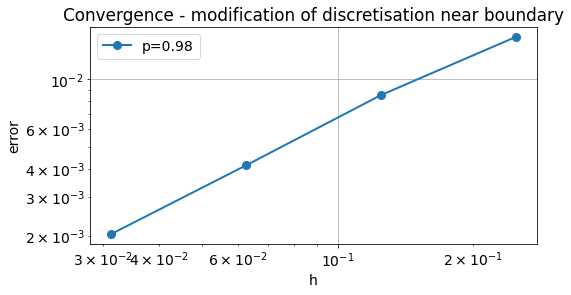

In [ ]:
def convergence_irregular(exact_func, M, solver): 
    P = 4
    Hconv = np.zeros(P)
    Econv = np.zeros(P)
    M = 4             
    for p in range(P):
        U_nf , x_nf, y_nf = solver(A_fat, f, bc_funk, M, grid, g_irregular, B_east_irregular, B_north_irregular, irregular = True)
        exact, x, y = exact_func(M)
        Eh = exact-U_nf
        Hconv[p] = (x[1]-x[0])
        Econv[p] = np.max(np.abs(Eh[1:-1, 1:-1]))
        M = 2*M
        
    order = np.polyfit(np.log(Hconv),np.log(Econv),1)[0]
    return Hconv, Econv, order

H, E, p = convergence_irregular(exact_sol, 4, solver_task2)
#print(H,E)
plt.loglog(H,E,'o-', label='p={:.2f}'.format(p))
plt.title("Convergence - modification of discretisation near boundary")
plt.grid('on')
plt.xlabel('h')
plt.ylabel('error')
plt.legend();

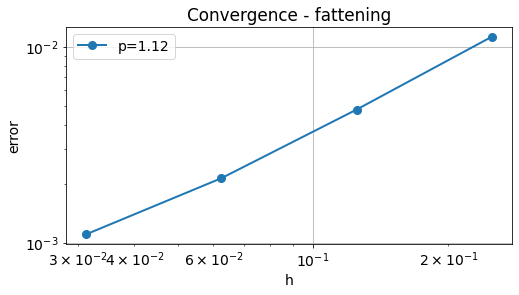

In [ ]:
def convergence_fattening(exact_func, M, solver): 
    P =4
    Hconv = np.zeros(P)
    Econv = np.zeros(P)
    M = 4             
    for p in range(P):
        U_fat , x, y = solver(A_fat, f, bc_funk, M, grid, g_fattening, B_east_irregular, B_north_irregular, irregular = False)
        exact, x, y =exact_func(M)
        Eh = exact-U_fat
        Hconv[p] = (x[1]-x[0])
        Econv[p] = np.mean(np.abs(Eh[1:-1, 1:-1]))
        M = 2*M
    order = np.polyfit(np.log(Hconv),np.log(Econv),1)[0]
    return Hconv, Econv, order

H, E, p = convergence_fattening(exact_sol, 4, solver_task2)
plt.loglog(H,E,'o-', label='p={:.2f}'.format(p))
plt.grid('on')
plt.title("Convergence - fattening")
plt.xlabel('h')
plt.ylabel('error')
plt.legend();

Less error for irregular, so we can try to plot convergence. Still get an error at the beginning that can make the convergence plot difficult